# Tutorial: fitting a FSRQ broad-band SED using angpy and Gammapy

In this tutorial we will show how to use `Gammapy` to wrap `agnpy` functions to perform the fit of the broad-band SED of PKS1510-089, measured during its gamma-ray flaring activity in 2015 [(Ahnen et al. 2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...603A..29A/abstract). We select the MWL SED corresponding to the period identified in the paper as "Period B" (MJD 57164-57166). 

[Gammapy](https://gammapy.org/) is required to run this notebook.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import pkg_resources
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.constants import k_B, m_e, c, G, M_sun
from astropy.table import Table
from astropy.coordinates import Distance
import matplotlib.pyplot as plt

# import agnpy classes
from agnpy.spectra import BrokenPowerLaw
from agnpy.emission_regions import Blob
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton, ExternalCompton
from agnpy.targets import SSDisk, RingDustTorus
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label

# import gammapy classes
from gammapy.modeling.models import (
    SpectralModel,
    Parameter,
    SPECTRAL_MODEL_REGISTRY,
    SkyModel,
)
from gammapy.estimators import FluxPoints
from gammapy.datasets import FluxPointsDataset
from gammapy.modeling import Fit

# constants
mec2 = m_e.to("erg", equivalencies=u.mass_energy())
gamma_size = 400
gamma_to_integrate = np.logspace(0, 7, gamma_size)

### gammapy wrapper of agnpy radiative processes
Now let us [follow the Gammapy documentation](https://docs.gammapy.org/0.18.2/tutorials/models.html#Implementing-a-Custom-Model) and define a model wrapping agnpy's functions to compute the Synchrotron, Synchrotron Self-Compton and External Compton on Dust Torus SEDs. We will assume a broken power-law electron distribution. The thermal SEDs of the Disk and the DT are added to the total flux model.

**NOTE:** for the parameters that vary over several orders of magnitude (i.e. normalisation and Lorentz factors of the electron distribution) it is better to provide to the fitting routine a "scaled" version of them (e.g. their log10), such that larger ranges might be covered with small parameters variation.

**NOTE:** the size of the blob $R_{\rm b}$ is constrained through the variability time scale, $t_{\rm var}$, and the Doppler factor, $\delta_{\rm D}$, via: $R_{\rm b} = (c t_{\rm var} \delta_{\rm D}) / (1 + z)$.

In [2]:
class AgnpyEC(SpectralModel):
    """Wrapper of agnpy's non synchrotron, SSC and EC classes. The flux model
    accounts for the Disk and DT's thermal SEDs. 
    A broken power law is assumed for the electron spectrum.
    To limit the span of the parameters space, we fit the log10 of the parameters 
    whose range is expected to cover several orders of magnitudes (normalisation, 
    gammas, size and magnetic field of the blob). 
    """

    tag = "EC"
    log10_k_e = Parameter("log10_k_e", -5, min=-20, max=2)
    p1 = Parameter("p1", 2.1, min=1.0, max=5.0)
    p2 = Parameter("p2", 3.1, min=1.0, max=5.0)
    log10_gamma_b = Parameter("log10_gamma_b", 3, min=1, max=6)
    log10_gamma_min = Parameter("log10_gamma_min", 1, min=0, max=4)
    log10_gamma_max = Parameter("log10_gamma_max", 5, min=3, max=8)
    # source general parameters
    z = Parameter("z", 0.1, min=0.01, max=1)
    d_L = Parameter("d_L", "1e27 cm", min=1e25, max=1e33)
    # emission region parameters
    delta_D = Parameter("delta_D", 10, min=1, max=40)
    log10_B = Parameter("log10_B", 0.0, min=-3.0, max=1.0)
    t_var = Parameter("t_var", "600 s", min=10, max=np.pi * 1e7)
    mu_s = Parameter("mu_s", 0.9, min=0.0, max=1.0)
    log10_r = Parameter("log10_r", 17.0, min=16.0, max=20.0)
    # disk parameters
    log10_L_disk = Parameter("log10_L_disk", 45.0, min=42.0, max=48.0)
    log10_M_BH = Parameter("log10_M_BH", 42, min=32, max=45)
    m_dot = Parameter("m_dot", "1e26 g s-1", min=1e24, max=1e30)
    R_in = Parameter("R_in", "1e14 cm", min=1e12, max=1e16)
    R_out = Parameter("R_out", "1e17 cm", min=1e12, max=1e19)
    # DT parameters
    xi_dt = Parameter("xi_dt", 0.6, min=0.0, max=1.0)
    T_dt = Parameter("T_dt", "1e3 K", min=1e2, max=1e4)
    R_dt = Parameter("R_dt", "2.5e18 cm", min=1.0e17, max=1.0e19)

    @staticmethod
    def evaluate(
        energy,
        log10_k_e,
        p1,
        p2,
        log10_gamma_b,
        log10_gamma_min,
        log10_gamma_max,
        z,
        d_L,
        delta_D,
        log10_B,
        t_var,
        mu_s,
        log10_r,
        log10_L_disk,
        log10_M_BH,
        m_dot,
        R_in,
        R_out,
        xi_dt,
        T_dt,
        R_dt,
    ):
        # conversion
        k_e = 10 ** log10_k_e * u.Unit("cm-3")
        gamma_b = 10 ** log10_gamma_b
        gamma_min = 10 ** log10_gamma_min
        gamma_max = 10 ** log10_gamma_max
        B = 10 ** log10_B * u.G
        R_b = (c * t_var * delta_D / (1 + z)).to("cm")
        r = 10 ** log10_r * u.cm
        L_disk = 10 ** log10_L_disk * u.Unit("erg s-1")
        M_BH = 10 ** log10_M_BH * u.Unit("g")
        eps_dt = 2.7 * (k_B * T_dt / mec2).to_value("")

        nu = energy.to("Hz", equivalencies=u.spectral())
        # non-thermal components
        sed_synch = Synchrotron.evaluate_sed_flux(
            nu,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            ssa=True,
            gamma=gamma_to_integrate,
        )
        sed_ssc = SynchrotronSelfCompton.evaluate_sed_flux(
            nu,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            ssa=True,
            gamma=gamma_to_integrate,
        )
        sed_ec_dt = ExternalCompton.evaluate_sed_flux_dt(
            nu,
            z,
            d_L,
            delta_D,
            mu_s,
            R_b,
            L_disk,
            xi_dt,
            eps_dt,
            R_dt,
            r,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            gamma=gamma_to_integrate,
        )
        # thermal components
        sed_bb_disk = SSDisk.evaluate_multi_T_bb_norm_sed(
            nu, z, L_disk, M_BH, m_dot, R_in, R_out, d_L
        )
        sed_bb_dt = RingDustTorus.evaluate_bb_norm_sed(
            nu, z, xi_dt * L_disk, T_dt, R_dt, d_L
        )
        sed = sed_synch + sed_ssc + sed_ec_dt + sed_bb_disk + sed_bb_dt
        return (sed / energy ** 2).to("1 / (cm2 eV s)")

# IMPORTANT: add the new custom model to the registry of spectral models recognised by gammapy
SPECTRAL_MODEL_REGISTRY.append(AgnpyEC)

### Fit with gammapy
Let us start here the procedure to fit with Gammapy

#### 1) load the MWL flux points 
The MWL SEDs included in the default `agnpy` data are automatically readable by `Gammapy`'s `FluxPoints`

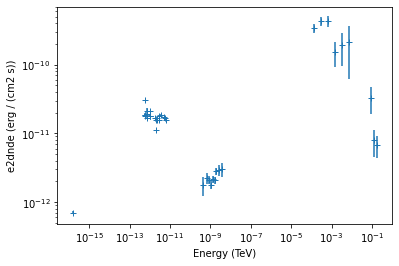

In [3]:
sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/PKS1510-089_2015b.ecsv")
flux_points = FluxPoints.read(sed_path)
flux_points.plot()
plt.show()

#### 2) add systematic errors
Currently there is no function in gammapy handling systematic errors on flux points.    
Let us manually add different systematic errors in different energy bands.     
We assume them to be independent from the statistical ones and sum them in quadrature.

In [4]:
# array of systematic errors, will just be summed in quadrature to the statistical error
# we assume
# - 30% on VHE gamma-ray instruments
# - 10% on HE gamma-ray instruments
# - 10% on X-ray instruments
# - 5% on lower-energy instruments
x = flux_points.table["e_ref"]
y = flux_points.table["e2dnde"]
y_err_stat = flux_points.table["e2dnde_errn"]
y_err_syst = np.zeros(len(x))
# define energy ranges
e_vhe = 100 * u.GeV
e_he = 0.1 * u.GeV
e_x_ray_max = 300 * u.keV
e_x_ray_min = 0.3 * u.keV
vhe_gamma = x >= e_vhe
he_gamma = (x >= e_he) * (x < e_vhe)
x_ray = (x >= e_x_ray_min) * (x < e_x_ray_max)
uv_to_radio = x < e_x_ray_min
# declare systematics
y_err_syst[vhe_gamma] = 0.30
y_err_syst[he_gamma] = 0.10
y_err_syst[x_ray] = 0.10
y_err_syst[uv_to_radio] = 0.05
y_err_syst = y * y_err_syst
# sum in quadrature the errors
flux_points.table["e2dnde_err"] = np.sqrt(y_err_stat ** 2 + y_err_syst ** 2)
# convert to "dnde" SED type to fit
flux_points = flux_points.to_sed_type("dnde")

#### 3) perform the fit
Now we create an instance of the model wrapping the non-thermal and thermal emissions.    
Let us leave free to vary the parameters describing the electron distribution and the magnetic field.

In [5]:
# declare a model
agnpy_ec = AgnpyEC()
# global parameters of the blob and the DT
z = 0.361
d_L = Distance(z=z).to("cm")
# blob
Gamma = 20
delta_D = 25
Beta = np.sqrt(1 - 1 / np.power(Gamma, 2))  # jet relativistic speed
mu_s = (1 - 1 / (Gamma * delta_D)) / Beta  # viewing angle
B = 0.35 * u.G
# disk
L_disk = 6.7e45 * u.Unit("erg s-1")  # disk luminosity
M_BH = 5.71 * 1e7 * M_sun
eta = 1 / 12
m_dot = (L_disk / (eta * c ** 2)).to("g s-1")
R_g = ((G * M_BH) / c ** 2).to("cm")
R_in = 6 * R_g
R_out = 10000 * R_g
# DT
xi_dt = 0.6  # fraction of disk luminosity reprocessed by the DT
T_dt = 1e3 * u.K
R_dt = 6.47 * 1e18 * u.cm
# size and location of the emission region
t_var = 0.5 * u.d
r = 6e17 * u.cm
# instance of the model wrapping angpy functionalities
# - AGN parameters
# -- distances
agnpy_ec.z.quantity = z
agnpy_ec.z.frozen = True
agnpy_ec.d_L.quantity = d_L.cgs.value
agnpy_ec.d_L.frozen = True
# -- SS disk
agnpy_ec.log10_L_disk.quantity = np.log10(L_disk.to_value("erg s-1"))
agnpy_ec.log10_L_disk.frozen = True
agnpy_ec.log10_M_BH.quantity = np.log10(M_BH.to_value("g"))
agnpy_ec.log10_M_BH.frozen = True
agnpy_ec.m_dot.quantity = m_dot
agnpy_ec.m_dot.frozen = True
agnpy_ec.R_in.quantity = R_in
agnpy_ec.R_in.frozen = True
agnpy_ec.R_out.quantity = R_out
agnpy_ec.R_out.frozen = True
# -- Dust Torus
agnpy_ec.xi_dt.quantity = xi_dt
agnpy_ec.xi_dt.frozen = True
agnpy_ec.T_dt.quantity = T_dt
agnpy_ec.T_dt.frozen = True
agnpy_ec.R_dt.quantity = R_dt
agnpy_ec.R_dt.frozen = True
# - blob parameters
agnpy_ec.delta_D.quantity = delta_D
agnpy_ec.delta_D.frozen = True
agnpy_ec.log10_B.quantity = np.log10(B.to_value("G"))
agnpy_ec.mu_s.quantity = mu_s
agnpy_ec.mu_s.frozen = True
agnpy_ec.t_var.quantity = t_var
agnpy_ec.t_var.frozen = True
agnpy_ec.log10_r.quantity = np.log10(r.to_value("cm"))
agnpy_ec.log10_r.frozen = True
# - EED
agnpy_ec.log10_k_e.quantity = np.log10(0.05)
agnpy_ec.p1.quantity = 1.8
agnpy_ec.p2.quantity = 3.5
agnpy_ec.log10_gamma_b.quantity = np.log10(500)
agnpy_ec.log10_gamma_min.quantity = np.log10(1)
agnpy_ec.log10_gamma_min.frozen = True
agnpy_ec.log10_gamma_max.quantity = np.log10(3e4)
agnpy_ec.log10_gamma_max.frozen = True

Let us define the skymodel and perform the fit

In [6]:
# define model
model = SkyModel(name="PKS1510-089_EC", spectral_model=agnpy_ec)
dataset_ec = FluxPointsDataset(model, flux_points)
# do not use frequency point below 1e11 Hz, affected by non-blazar emission
E_min_fit = (1e11 * u.Hz).to("eV", equivalencies=u.spectral())
dataset_ec.mask_fit = dataset_ec.data.energy_ref > E_min_fit

/home/cosimo/software/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: divide by zero encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/home/cosimo/software/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: invalid value encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/home/cosimo/software/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda

In [7]:
%%time
# define the fitter
fitter = Fit([dataset_ec])
results = fitter.run(optimize_opts={"print_level": 1})
print(results)
print(agnpy_ec.parameters.to_table())

/home/cosimo/software/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: divide by zero encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/home/cosimo/software/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: invalid value encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/home/cosimo/software/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda

------------------------------------------------------------------
| FCN = 202.1                   |     Ncalls=197 (197 total)     |
| EDM = 4.45E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 197
	total stat : 202.07

      name         value   

#### 4) visualise the fit results

/home/cosimo/software/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: divide by zero encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/home/cosimo/software/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: invalid value encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/home/cosimo/software/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda

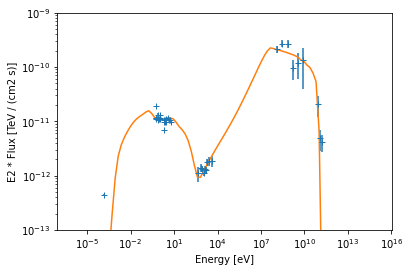

In [8]:
# plot best-fit model and covariance
flux_points.plot(energy_unit="eV", energy_power=2)
agnpy_ec.plot(energy_range=[1e-6, 1e15] * u.eV, energy_unit="eV", energy_power=2)
plt.ylim([10 ** (-13), 10 ** (-9)])
plt.show()

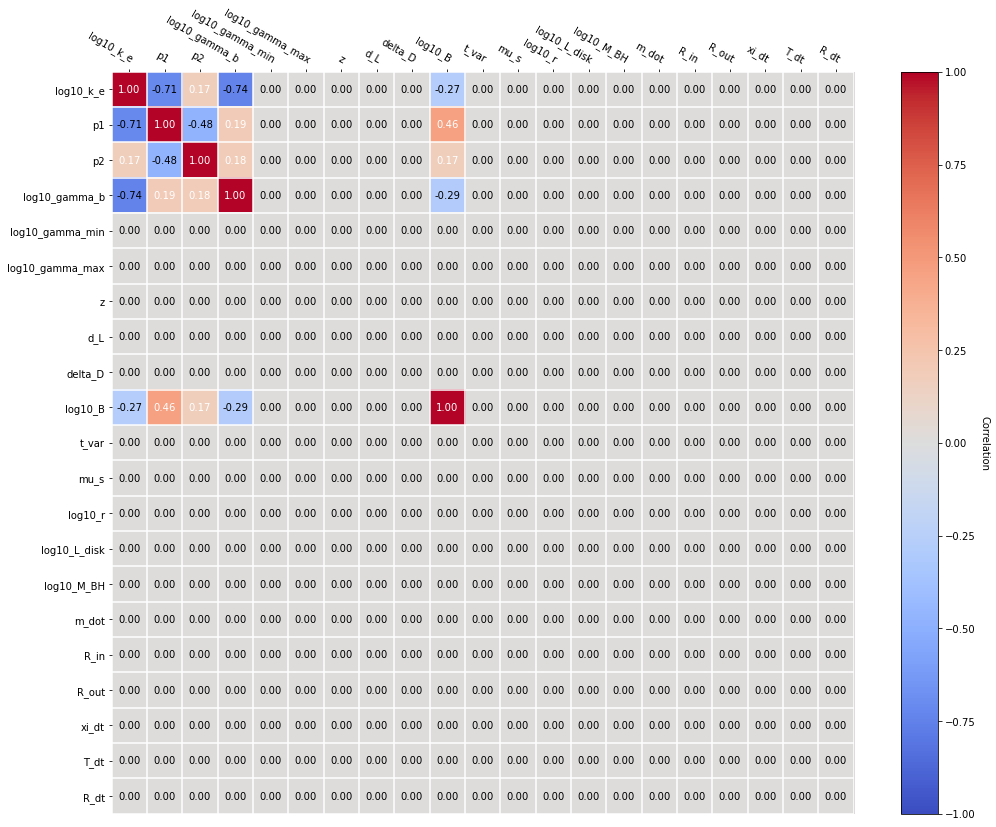

In [9]:
# we can use Gammapy functions to plot the covariance
agnpy_ec.covariance.plot_correlation()
plt.show()

#### Use Gammapy best-fit parameters and agnpy to plot the best-fit model specifying its individual components
We fetch the best-fit parameters for our model and we use them to specify and plot the individual spectral components.

In [10]:
# define the emission region and the thermal emitters
k_e = 10 ** agnpy_ec.log10_k_e.value * u.Unit("cm-3")
p1 = agnpy_ec.p1.value
p2 = agnpy_ec.p2.value
gamma_b = 10 ** agnpy_ec.log10_gamma_b.value
gamma_min = 10 ** agnpy_ec.log10_gamma_min.value
gamma_max = 10 ** agnpy_ec.log10_gamma_max.value
B = 10 ** agnpy_ec.log10_B.value * u.G
r = 10 ** agnpy_ec.log10_r.value * u.cm
delta_D = agnpy_ec.delta_D.value
R_b = (
    c * agnpy_ec.t_var.quantity * agnpy_ec.delta_D.quantity / (1 + agnpy_ec.z.quantity)
).to("cm")
# blob definition
parameters = {
    "p1": p1,
    "p2": p2,
    "gamma_b": gamma_b,
    "gamma_min": gamma_min,
    "gamma_max": gamma_max,
}
spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters}
blob = Blob(
    R_b,
    z,
    delta_D,
    Gamma,
    B,
    k_e,
    spectrum_dict,
    spectrum_norm_type="differential",
    gamma_size=500,
)
print(blob)
print(f"jet power in particles: {blob.P_jet_e:.2e}")
print(f"jet power in B: {blob.P_jet_B:.2e}")

# Disk and DT definition
L_disk = 10 ** agnpy_ec.log10_L_disk.value * u.Unit("erg s-1")
M_BH = 10 ** agnpy_ec.log10_M_BH.value * u.Unit("g")
m_dot = agnpy_ec.m_dot.value * u.Unit("g s-1")
eta = (L_disk / (m_dot * c ** 2)).to_value("")
R_in = agnpy_ec.R_in.value * u.cm
R_out = agnpy_ec.R_out.value * u.cm
disk = SSDisk(M_BH, L_disk, eta, R_in, R_out)
dt = RingDustTorus(L_disk, xi_dt, T_dt, R_dt=R_dt)
print(disk)
print(dt)

* spherical emission region
 - R_b (radius of the blob): 2.38e+16 cm
 - V_b (volume of the blob): 5.64e+49 cm3
 - z (source redshift): 0.36
 - d_L (source luminosity distance):6.13e+27 cm
 - delta_D (blob Doppler factor): 2.50e+01
 - Gamma (blob Lorentz factor): 2.00e+01
 - Beta (blob relativistic velocity): 9.99e-01
 - theta_s (jet viewing angle): 2.22e+00 deg
 - B (magnetic field tangled to the jet): 3.72e-01 G
 - xi (coefficient for 1st order Fermi acceleration) : 1.00e+00
* electron spectrum
 - broken power law
 - k_e: 5.02e-02 1 / cm3
 - p1: 1.75
 - p2: 3.13
 - gamma_b: 5.01e+02
 - gamma_min: 1.00e+00
 - gamma_max: 3.00e+04

jet power in particles: 1.78e+45 erg / s
jet power in B: 2.35e+44 erg / s
* Shakura Sunyaev accretion disk:
 - M_BH (central black hole mass): 1.14e+41 g
 - L_disk (disk luminosity): 6.70e+45 erg / s
 - eta (accretion efficiency): 8.33e-02
 - dot(m) (mass accretion rate): 8.95e+25 g / s
 - R_in (disk inner radius): 5.06e+13 cm
 - R_out (disk inner radius): 8.4

In [11]:
# define the radiative processes
synch = Synchrotron(blob, ssa=True)
ssc = SynchrotronSelfCompton(blob, synch)
ec_dt = ExternalCompton(blob, dt, r)
# SEDs
nu = np.logspace(9, 27, 200) * u.Hz
synch_sed = synch.sed_flux(nu)
ssc_sed = ssc.sed_flux(nu)
ec_dt_sed = ec_dt.sed_flux(nu)
disk_bb_sed = disk.sed_flux(nu, z)
dt_bb_sed = dt.sed_flux(nu, z)
total_sed = synch_sed + ssc_sed + ec_dt_sed + disk_bb_sed + dt_bb_sed

/home/cosimo/software/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: divide by zero encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/home/cosimo/software/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: invalid value encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/home/cosimo/software/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda

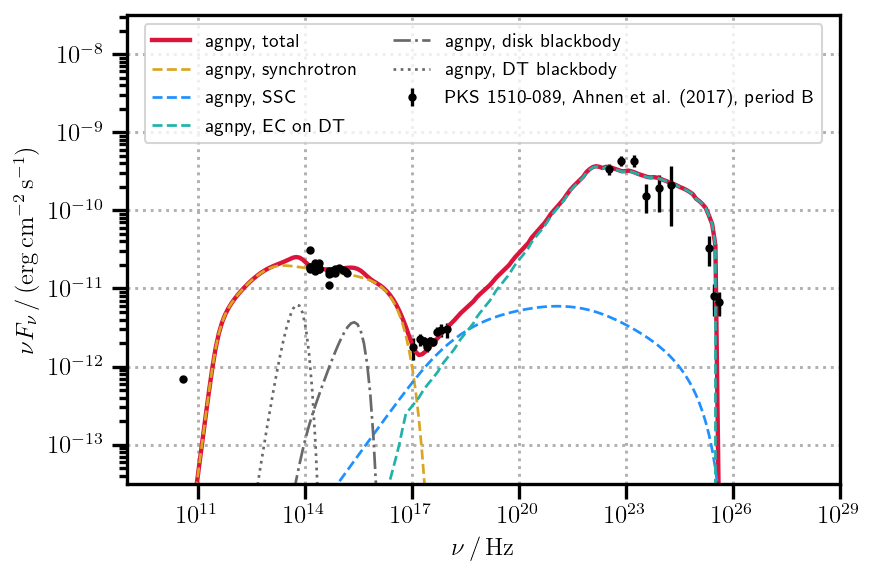

In [12]:
# plot everything
load_mpl_rc()
plt.rcParams["text.usetex"] = True
fig, ax = plt.subplots()
ax.loglog(
    nu / (1 + z), total_sed, ls="-", lw=2.1, color="crimson", label="agnpy, total"
)
ax.loglog(
    nu / (1 + z),
    synch_sed,
    ls="--",
    lw=1.3,
    color="goldenrod",
    label="agnpy, synchrotron",
)
ax.loglog(
    nu / (1 + z), ssc_sed, ls="--", lw=1.3, color="dodgerblue", label="agnpy, SSC"
)
ax.loglog(
    nu / (1 + z),
    ec_dt_sed,
    ls="--",
    lw=1.3,
    color="lightseagreen",
    label="agnpy, EC on DT",
)
ax.loglog(
    nu / (1 + z),
    disk_bb_sed,
    ls="-.",
    lw=1.3,
    color="dimgray",
    label="agnpy, disk blackbody",
)
ax.loglog(
    nu / (1 + z),
    dt_bb_sed,
    ls=":",
    lw=1.3,
    color="dimgray",
    label="agnpy, DT blackbody",
)
# systematics error in gray
ax.errorbar(
    x.to("Hz", equivalencies=u.spectral()).value,
    y,
    yerr=y_err_syst,
    marker=",",
    ls="",
    color="gray",
    label="",
)
# statistics error in black
ax.errorbar(
    x.to("Hz", equivalencies=u.spectral()).value,
    y,
    yerr=y_err_stat,
    marker=".",
    ls="",
    color="k",
    label="PKS 1510-089, Ahnen et al. (2017), period B",
)
ax.set_xlabel(sed_x_label)
ax.set_ylabel(sed_y_label)
ax.set_xlim([1e9, 1e29])
ax.set_ylim([10 ** (-13.5), 10 ** (-7.5)])
ax.legend(
    loc="upper center", fontsize=9, ncol=2,
)
plt.show()